In [1]:
import gribscan
import numcodecs
import xarray as xr
import matplotlib.pylab as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib import cm
import intake
import xarray as xr
import matplotlib.pylab as plt
import numpy as np
%matplotlib inline
xr.set_options(display_style="text") # make it look better when posted online. Comment to get nicer representation of xarrays
import matplotlib.cm as cm
from scipy.spatial import cKDTree
import pandas as pd

In [18]:
# catalogs so far only work on the DKRZ supercomputer; below data are downloaded
# cat = intake.open_catalog("https://data.nextgems-h2020.eu/catalog.yaml")
# data = cat['IFS']['IFS_4.4-FESOM_5-cycle3']['2D_1h_native'].to_dask()
# data[['10u', '10v']].isel(time=400).to_netcdf('/work/ab0995/a270088/NextGems/NG_paper/IFS_4.4-FESOM_5-cycle3_uv_timestep_400.nc')

##### cd somewhere with about 3GB space

In [4]:
# download data (3GB) to current directory
! wget https://swift.dkrz.de/v1/dkrz_035d8f6ff058403bb42f8302e6badfbc/NEXTGEMS/IFS_4.4-FESOM_5-cycle3_uv_timestep_400.nc
! wget https://swift.dkrz.de/v1/dkrz_035d8f6ff058403bb42f8302e6badfbc/NEXTGEMS/tco2559_grid.nc

--2023-09-12 16:09:06--  https://swift.dkrz.de/v1/dkrz_035d8f6ff058403bb42f8302e6badfbc/NEXTGEMS/IFS_4.4-FESOM_5-cycle3_uv_timestep_400.nc
Resolving swift.dkrz.de (swift.dkrz.de)... 136.172.36.73, 136.172.36.74, 136.172.36.75, ...
Connecting to swift.dkrz.de (swift.dkrz.de)|136.172.36.73|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 841822449 (803M) [application/x-netcdf]
Saving to: ‘IFS_4.4-FESOM_5-cycle3_uv_timestep_400.nc’

IFS_4.4-FESOM_5-cyc 100%[===================>] 802.82M   205MB/s    in 3.9s    

2023-09-12 16:09:10 (204 MB/s) - ‘IFS_4.4-FESOM_5-cycle3_uv_timestep_400.nc’ saved [841822449/841822449]

--2023-09-12 16:09:10--  https://swift.dkrz.de/v1/dkrz_035d8f6ff058403bb42f8302e6badfbc/NEXTGEMS/tco2559_grid.nc
Resolving swift.dkrz.de (swift.dkrz.de)... 136.172.36.75, 136.172.36.73, 136.172.36.74, ...
Connecting to swift.dkrz.de (swift.dkrz.de)|136.172.36.75|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2209759351 (2.1G)

In [5]:
grid = xr.open_dataset('./tco2559_grid.nc')

In [6]:
model_lon = grid.clon.values*180./np.pi
model_lat = grid.clat.values*180./np.pi
model_lon = np.where(model_lon>180, model_lon-360, model_lon)

In [7]:
data = xr.open_dataset('./IFS_4.4-FESOM_5-cycle3_uv_timestep_400.nc')

In [8]:
def lon_lat_to_cartesian(lon, lat, R=6371000):
    """
    calculates lon, lat coordinates of a point on a sphere with
    radius R. Taken from http://earthpy.org/interpolation_between_grids_with_ckdtree.html
    """
    lon_r = np.radians(lon)
    lat_r = np.radians(lat)

    x = R * np.cos(lat_r) * np.cos(lon_r)
    y = R * np.cos(lat_r) * np.sin(lon_r)
    z = R * np.sin(lat_r)
    return x, y, z

In [9]:
def create_indexes_and_distances(model_lon, model_lat, lons, lats, k=1):
    """
    Creates KDTree object and query it for indexes of points in FESOM mesh that are close to the
    points of the target grid. Also return distances of the original points to target points.
    Parameters
    ----------
    mesh : fesom_mesh object
        pyfesom mesh representation
    lons/lats : array
        2d arrays with target grid values.
    k : int
        k-th nearest neighbors to return.
    n_jobs : int, optional
        Number of jobs to schedule for parallel processing. If -1 is given
        all processors are used. Default: 1.
    Returns
    -------
    distances : array of floats
        The distances to the nearest neighbors.
    inds : ndarray of ints
        The locations of the neighbors in data.
    """
    xs, ys, zs = lon_lat_to_cartesian(model_lon, model_lat)
    xt, yt, zt = lon_lat_to_cartesian(lons.flatten(), lats.flatten())

    tree = cKDTree(list(zip(xs, ys, zs)))
    distances, inds = tree.query(list(zip(xt, yt, zt)), k=k,)

    return distances, inds

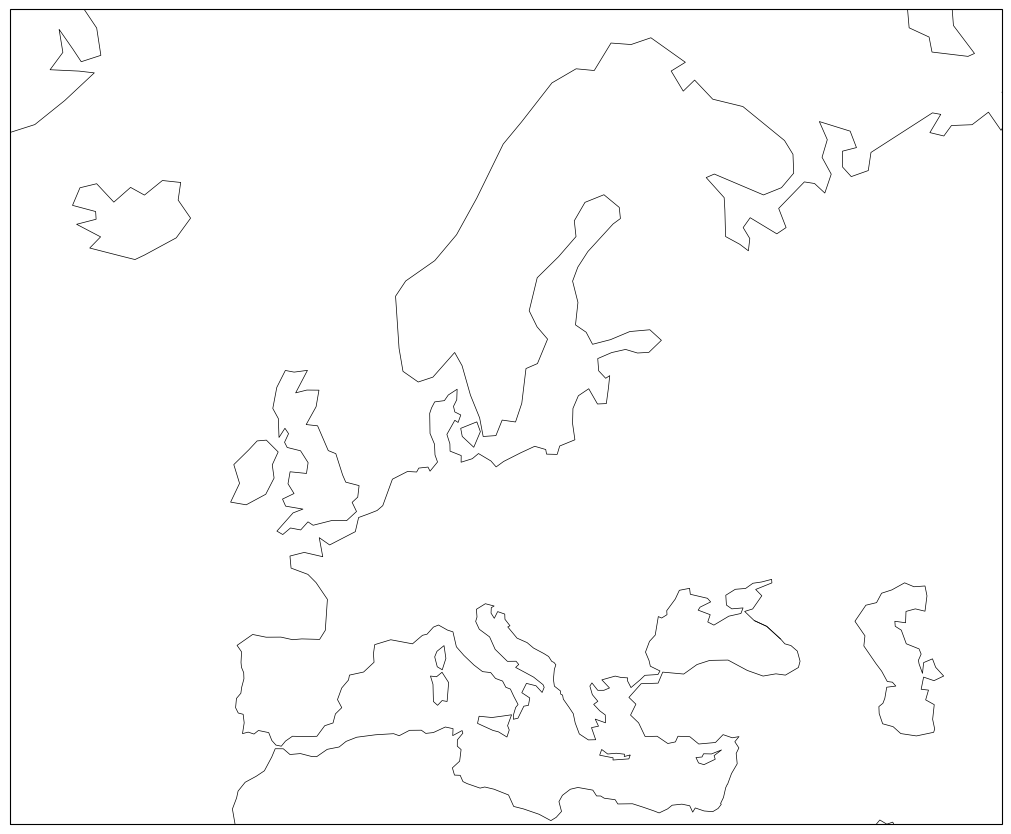

In [10]:
left = -30
right = 60
bottom = 30
top = 72
fig, ax = plt.subplots(
            1,
            1,
            subplot_kw=dict(projection=ccrs.Mercator()),
            constrained_layout=True,
            figsize=(10,10),
        )
sstep = 10
ax.set_extent([left, right, bottom, top], crs=ccrs.PlateCarree())
ax.coastlines(resolution = '110m',lw=0.5)

In [11]:
xmin, xmax = ax.get_xbound()
ymin, ymax = ax.get_ybound()

In [12]:
# scl_fac = 0.000005
scl_fac = 0.0002
res = 2000#scl_fac * 30. # last number is the grid resolution in meters (NEEDS TO BE CHANGED)
nx = int((xmax-xmin)/res)+1; ny = int((ymax-ymin)/res)+1
x = np.linspace(xmin,xmax,nx)
y = np.linspace(ymin,ymax,ny)
x,y = np.meshgrid(x,y)

In [13]:
npstere = ccrs.PlateCarree()
# transformed2 =  npstere.transform_points(ccrs.NorthPolarStereo(), x, y)
transformed2 =  npstere.transform_points(ccrs.Mercator(), x, y)

In [14]:
x2 = transformed2[:,:,0]#.ravel()
y2 = transformed2[:,:,1]#.ravel()

In [15]:
distances, inds = create_indexes_and_distances(model_lon, model_lat, x2, y2, k=1,)

CPU times: user 824 ms, sys: 765 ms, total: 1.59 s
Wall time: 1.59 s


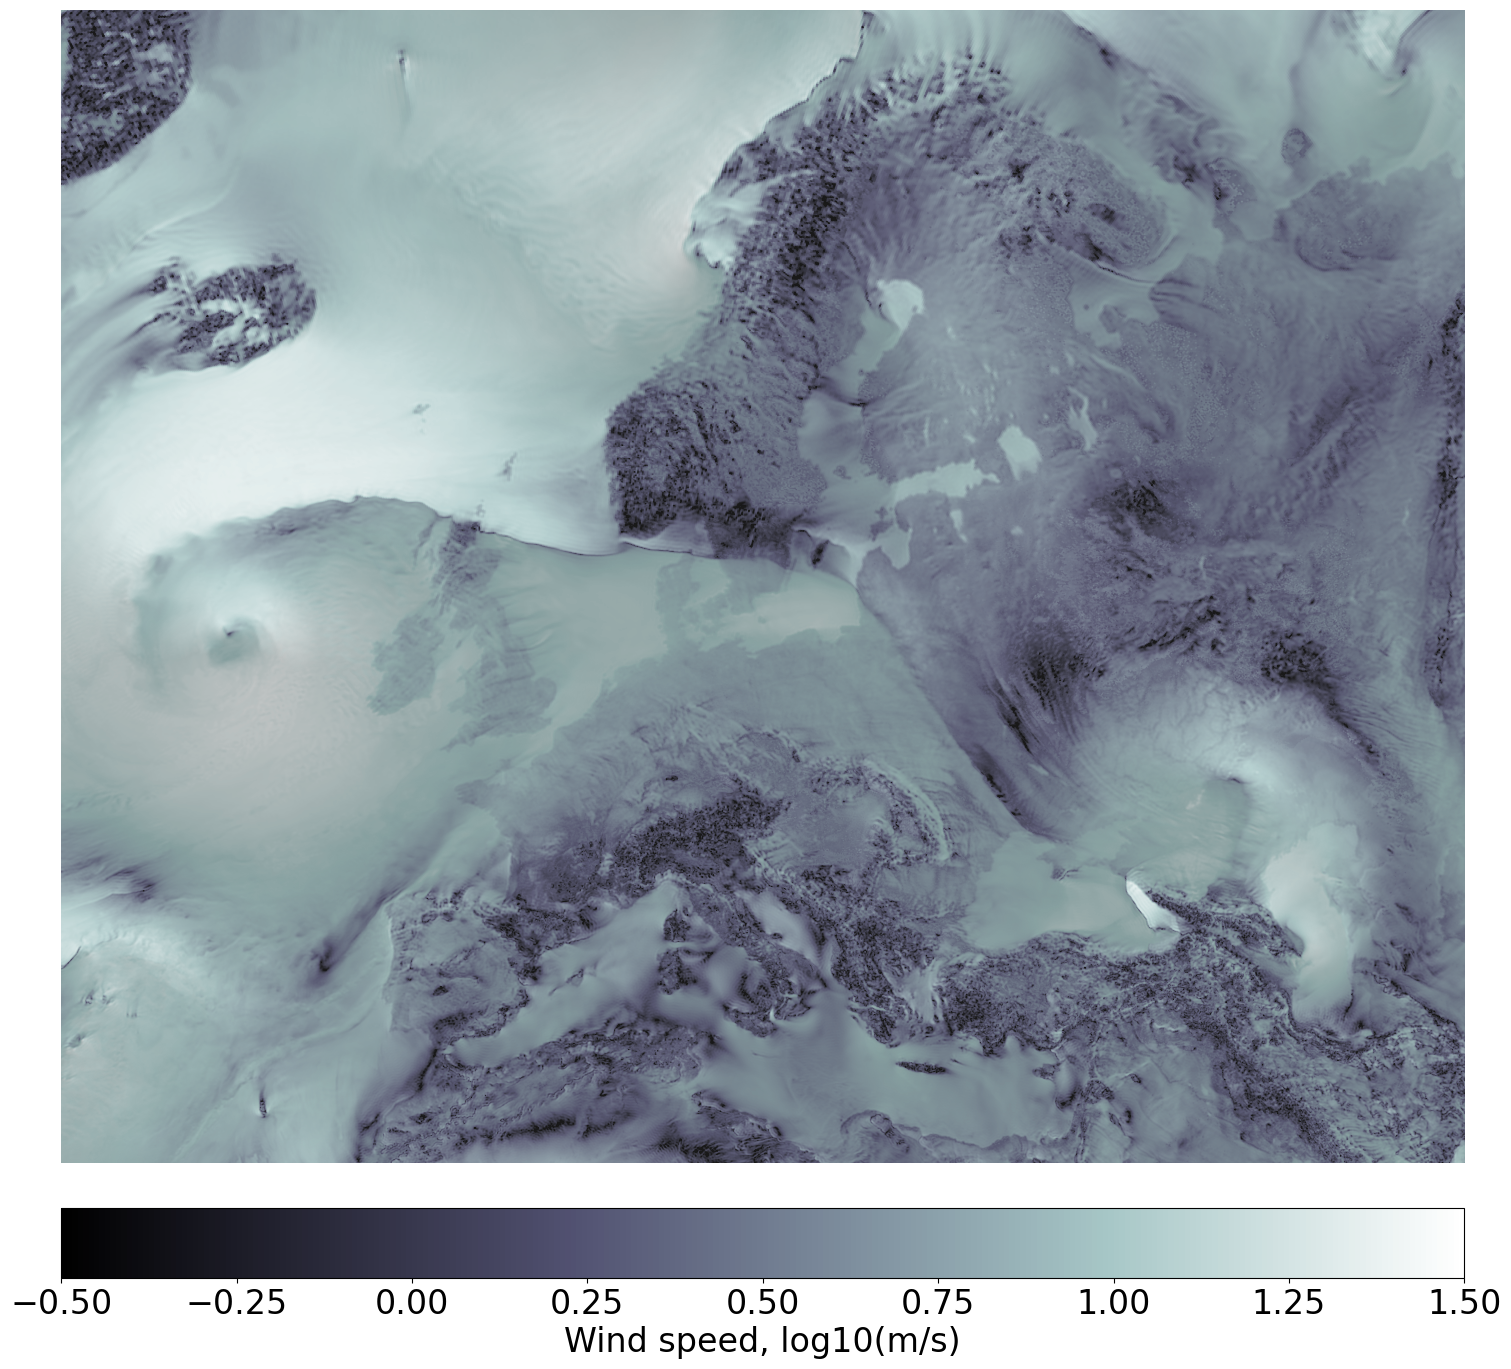

In [16]:
%%time
# ttime = 900
# ttime=400
speed = np.hypot(data['10u'].values, data['10v'].values)
speed_nonan = speed
u_nonan = data['10u'].values
# interpolated_u_fesom = u.uas[ttime,:].values[inds]
# interpolated_gust_fesom = gust.sfcWindGust[ttime,:].values[inds]
interpolated_u_fesom = u_nonan[inds]
interpolated_gust_fesom = speed_nonan[inds]
interpolated_u_fesom.shape = x2.shape
interpolated_gust_fesom.shape = x2.shape
fig, ax = plt.subplots(
            1,
            1,
            constrained_layout=True,
            figsize=(15,15),
        )
im = ax.imshow(np.flipud(np.log10(interpolated_gust_fesom)), cmap=cm.bone, vmin=-0.5, vmax=1.5)
ax.imshow(np.flipud(interpolated_u_fesom), alpha=0.2, cmap=cm.gray_r, vmin=-10, vmax=10)
ax.axis('off');
# plt.savefig(f'./{str(ttime).zfill(10)}.png', dpi=100)
cb = plt.colorbar(im, orientation="horizontal", pad=0.03)
cb.ax.tick_params(labelsize=24)
cb.set_label('Wind speed, log10(m/s)', size=24)